In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, Lambda, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Model, optimizers, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load dataset

In [ ]:
!gdown 'https://drive.google.com/uc?export=download&id=1phWikkOYex57DGxgNv3PgkF0pQ9Nsm1a'
!gdown 'https://drive.google.com/uc?export=download&id=1ykhOpo8ZjgDfbQ2CdR-zN-X_T8WEtL00'
!gdown 'https://drive.google.com/uc?export=download&id=1hzhmO5ZK_aVHUfGeWf3s4bHQPyl5EzUJ'

Downloading...
From: https://drive.google.com/uc?export=download&id=1phWikkOYex57DGxgNv3PgkF0pQ9Nsm1a
To: /content/Handwritten_V2_train.csv
100% 35.3M/35.3M [00:00<00:00, 51.5MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1ykhOpo8ZjgDfbQ2CdR-zN-X_T8WEtL00
To: /content/Handwritten_V2_valid.csv
100% 11.7M/11.7M [00:00<00:00, 58.0MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1hzhmO5ZK_aVHUfGeWf3s4bHQPyl5EzUJ
To: /content/Handwritten_V2_test.csv
100% 13.0M/13.0M [00:00<00:00, 44.4MB/s]


In [ ]:
train = pd.read_csv("Handwritten_V2_train.csv")
test = pd.read_csv("Handwritten_V2_test.csv")
validate = pd.read_csv("Handwritten_V2_valid.csv")

In [ ]:
train_images = train.iloc[:, 1:].values
test_images = test.iloc[:, 1:].values
train_labels = train.iloc[:, 0].values
test_labels = test.iloc[:, 0].values
validate_labels = validate.iloc[:, 0].values
validate_images = validate.iloc[:, 1:].values

#### Classes

In [ ]:
np.unique(train_labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85])

In [ ]:
train_images = np.concatenate([train_images.reshape(-1, 32, 32, 1)] * 3, axis=-1)
test_images = np.concatenate([test_images.reshape(-1, 32, 32, 1)] * 3, axis=-1)
validate_images = np.concatenate([validate_images.reshape(-1, 32, 32, 1)] * 3, axis=-1)

In [ ]:
train_images = tf.image.resize(train_images, [32, 32])
test_images = tf.image.resize(test_images, [32, 32])

In [ ]:
train_images.shape

TensorShape([17235, 32, 32, 3])

## One hot encoding

In [ ]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
validate_labels = to_categorical(validate_labels)

In [ ]:
train_labels.shape

(17235, 86)

In [ ]:
base_model = MobileNetV3Small(input_shape=(32, 32, 3), include_top=False, weights='imagenet')

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


###Freezing the base model

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 32, 32, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 16, 16,    │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 16, 16,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 17, 17,    │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 8, 8, 16)  │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 8, 8, 16)  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 8, 8, 16)  │          0 │ expanded_conv_de… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 8, 8, 16)  │          0 │ re_lu[0][0],      │
│ (Multiply)          │                   │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 8, 8, 16)  │        256 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                 

 Total params: 939,120 (3.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 939,120 (3.58 MB)

### Making trainable classifier

In [ ]:
inputs = Input(shape=(32, 32, 3))

# Pass inputs through the base model
x = base_model(inputs, training=False)

# Add pooling layer
x = GlobalAveragePooling2D()(x)

# Add dense layers
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

outputs = Dense(86, activation='softmax')(x)

In [ ]:
model = Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 1, 1, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 86)             │        11,094 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,132,358 (4.32 MB)

 Trainable params: 947,670 (3.62 MB)

 Non-trainable params: 184,688 (721.44 KB)

### Training the model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
epochs = 10

In [ ]:
history = model.fit(train_images,
                    train_labels,
                    epochs=epochs,
                    validation_data=(validate_images, validate_labels))

Epoch 1/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 0.1239 - loss: 3.9341 - val_accuracy: 0.0333 - val_loss: 4.7601
Epoch 2/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4643 - loss: 1.8631 - val_accuracy: 0.0335 - val_loss: 5.2224
Epoch 3/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6030 - loss: 1.3478 - val_accuracy: 0.0231 - val_loss: 4.8103
Epoch 4/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6598 - loss: 1.1089 - val_accuracy: 0.0375 - val_loss: 6.7378
Epoch 5/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7020 - loss: 0.9568 - val_accuracy: 0.0181 - val_loss: 8.4618
Epoch 6/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7295 - loss: 0.8848 - val_accuracy: 0.1348 - val_loss: 4.2486
Epoch 7/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7546 - loss: 0.8080 - val_accuracy: 0.1544 - val_loss: 4.0715
Epoch 8/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7632 - loss: 0.7520 - val_a

In [ ]:
model.evaluate(test_images, test_labels)

199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.1186 - loss: 5.4347


[5.538206100463867, 0.11794307082891464]

Unfreeze the last few layers of the base model

In [ ]:
for layer in base_model.layers[-40:]:
    layer.trainable = True

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
fine_history = model.fit(
    train_images,
    train_labels,
    epochs=20,
    validation_data=(validate_images, validate_labels),
    initial_epoch=history.epoch[-1]
)

Epoch 10/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 46s 47ms/step - accuracy: 0.8306 - loss: 0.5356 - val_accuracy: 0.4207 - val_loss: 2.4429
Epoch 11/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8524 - loss: 0.4583 - val_accuracy: 0.6957 - val_loss: 1.0250
Epoch 12/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8691 - loss: 0.4093 - val_accuracy: 0.7812 - val_loss: 0.6959
Epoch 13/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8743 - loss: 0.4012 - val_accuracy: 0.8449 - val_loss: 0.4842
Epoch 14/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8833 - loss: 0.3794 - val_accuracy: 0.8545 - val_loss: 0.4570
Epoch 15/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8858 - loss: 0.3601 - val_accuracy: 0.8736 - val_loss: 0.3923
Epoch 16/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8919 - loss: 0.3458 - val_accuracy: 0.8058 - val_loss: 0.6261
Epoch 17/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8986 - loss: 0.3267 - val_a

In [ ]:
model.evaluate(test_images, test_labels)

199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7521 - loss: 0.9028


[0.9518237113952637, 0.7395817041397095]

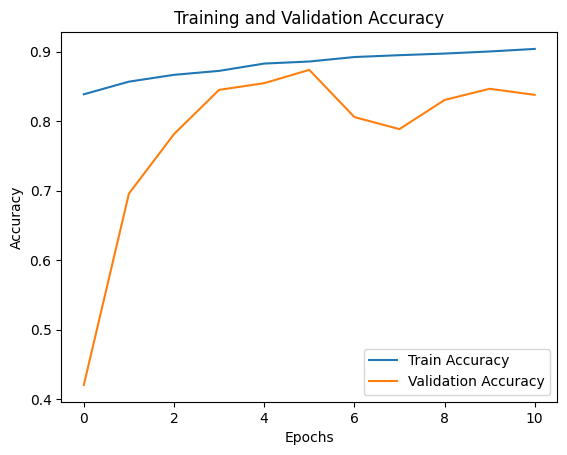

In [ ]:
# Plot training history
plt.plot(fine_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
model.save('char_recognition_mobilenetv3.keras')